### **Importing Libraries**

In [ ]:
import math
import random
from collections import defaultdict
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import copy
from Card_and_Deck import *
from GameState import *
from Game_and_Player import *
import time

### **Helper Functions**

In [ ]:

def simulate(game_state):
    """Simulates a random game from this state (play out the game to the end)."""
    game_state_new = copy.deepcopy(game_state)
    starting_player_index = game_state.current_player_index
    starting_player_name = game_state.players[starting_player_index].name

    while not game_state_new.is_terminal():
        legal_moves = game_state_new.get_legal_moves()
        if not legal_moves:
            break
        move = random.choice(legal_moves)
        game_state_new.apply_move(move)

    rewards=game_state_new.tricks_won

    winner_name = max(rewards, key=rewards.get)

    winner_index = next(i for i, player in enumerate(game_state_new.players) if player.name == winner_name)


    return winner_index


In [ ]:
def ucb_best_move(game_state, num_simulations=1000, exploration_constant=1.4):
    legal_moves = game_state.get_legal_moves()
    move_counts = {(move.suit,move.rank): 0 for move in legal_moves}
    move_wins = {(move.suit,move.rank): 0 for move in legal_moves}
    total_simulations = 0

    for _ in range(num_simulations):
        # UCB1: Select move
        ucb_scores = {}
        for move in legal_moves:
            if move_counts[(move.suit,move.rank)] == 0:
                ucb_scores[(move.suit,move.rank)] = float('inf')  # Explore each move at least once
            else:
                avg_win = move_wins[(move.suit,move.rank)] / move_counts[(move.suit,move.rank)]
                ucb_scores[(move.suit,move.rank)] = avg_win + exploration_constant * math.sqrt(
                    math.log(total_simulations + 1) / move_counts[(move.suit,move.rank)]
                )

        selected_move = max(ucb_scores, key=ucb_scores.get)
        sim_state = copy.deepcopy(game_state)
        sim_state.apply_move(selected_move)
        winner = simulate(sim_state)

        if winner == game_state.current_player_index:
            move_wins[selected_move] += 1

        move_counts[selected_move] += 1
        total_simulations += 1
    best_move = max(legal_moves, key=lambda m: move_wins[m] / move_counts[m])
    return best_move


In [ ]:
def ucb_best_move(game_state, num_simulations=1000, exploration_constant=0.4):
    legal_moves = game_state.get_legal_moves()
    sum_scores = {(move.suit,move.rank): 0.0 for move in legal_moves}
    visit_counts = {(move.suit,move.rank): 0 for move in legal_moves}

    for i in range(num_simulations):
        best_score = -float('inf')
        best_move = None

        for move in legal_moves:
            if visit_counts[(move.suit,move.rank)] == 0:
                score = float('inf')  # force exploration
            else:
                avg_score = sum_scores[(move.suit,move.rank)] / visit_counts[(move.suit,move.rank)]
                score = avg_score + exploration_constant * math.sqrt(
                    math.log(i + 1) / visit_counts[(move.suit,move.rank)]
                )

            if score > best_score:
                best_score = score
                best_move = move

        sim_state = copy.deepcopy(game_state)
        sim_state.apply_move(best_move)

        winner = simulate(sim_state)

        if winner == game_state.current_player_index:
            sum_scores[(best_move.suit,best_move.rank)] += 1
        else:
            sum_scores[(best_move.suit,best_move.rank)] += 0


        visit_counts[(best_move.suit,best_move.rank)] += 1

    best_move = max(legal_moves, key=lambda m: visit_counts[(m.suit,m.rank)])
    return best_move


### **Monte Carlo vs. Random Play (Baseline)**

In [ ]:
def evaluate_monte_carlo(num_games=1000, num_simulations=1000,c=0.707,verbose=True):
    monte_carlo_wins = 0
    win_results = []

    for _ in range(num_games):

        player_names = ["Alice", "Bob", "Charlie"]
        roles = ["Teen", "Do", "Paanch"]
        index = [0, 1, 2]



        game = Game(player_names, roles, index)
        game_state = GameState(game)

        game_state.current_player_index=random.choice(index)
        monte_carlo_player = random.choice(index)
        if verbose:
            print(f"Monte Carlo Player:{monte_carlo_player}")


        while not game_state.is_terminal():

            if game_state.current_player_index == monte_carlo_player:
                best_move = ucb_best_move(game_state, num_simulations,c)
            else:
                legal_moves1 = game_state.get_legal_moves()

                if not legal_moves1:
                    print(f"No legal moves for player {game_state.current_player_index}. Ending game.")
                    break

                best_move = random.choice(legal_moves1)
            game_state.apply_move(best_move)

        rewards = game_state.tricks_won
        if verbose==True:
           print(rewards)

        max_tricks = max(rewards.values())
        potential_winners = [name for name, count in rewards.items() if count == max_tricks]

        winner_name = potential_winners[0]
        monte_carlo_name = player_names[monte_carlo_player]



        if winner_name == monte_carlo_name:
            monte_carlo_wins += 1
            win_results.append(1)
            if verbose:
                print(f"Monte Carlo player won: {winner_name} ")
        else:
            win_results.append(0)
            if verbose:
                print(f"Monte Carlo player did not win: {winner_name} ")

    win_rate = monte_carlo_wins / num_games
    std_dev = np.std(win_results, ddof=1)

    print(f"Monte Carlo vs Random Win Rate: {win_rate:.2%}")
    print(f"Standard Deviation of Wins: {std_dev:.4f}")
    return win_rate



### **Testing different values of exploration constant**

In [ ]:
c_values = [0.1, 0.3,0.5,0.7, 0.8,0.9, 1.0,1.2, 1.5,1.7, 2.0]

results = []
times = []

for c in c_values:
    print(f"\nTesting with c = {c}")
    start = time.time()
    win_rate = evaluate_monte_carlo(num_games=100, num_simulations=100, c=c,verbose=False)
    end = time.time()

    elapsed_time = end - start
    results.append(win_rate)
    times.append(elapsed_time)

    print(f"Win Rate: {win_rate:.4f}")
    print(f"Execution Time: {elapsed_time:.4f} seconds")




Testing with c = 0.1
Monte Carlo vs Random Win Rate: 59.00%
Standard Deviation of Wins: 0.4943
Win Rate: 0.5900
Execution Time: 60.4195 seconds

Testing with c = 0.3
Monte Carlo vs Random Win Rate: 63.00%
Standard Deviation of Wins: 0.4852
Win Rate: 0.6300
Execution Time: 59.9026 seconds

Testing with c = 0.5
Monte Carlo vs Random Win Rate: 54.00%
Standard Deviation of Wins: 0.5009
Win Rate: 0.5400
Execution Time: 58.9058 seconds

Testing with c = 0.7
Monte Carlo vs Random Win Rate: 65.00%
Standard Deviation of Wins: 0.4794
Win Rate: 0.6500
Execution Time: 60.4599 seconds

Testing with c = 0.8
Monte Carlo vs Random Win Rate: 50.00%
Standard Deviation of Wins: 0.5025
Win Rate: 0.5000
Execution Time: 60.4457 seconds

Testing with c = 0.9
Monte Carlo vs Random Win Rate: 53.00%
Standard Deviation of Wins: 0.5016
Win Rate: 0.5300
Execution Time: 60.4873 seconds

Testing with c = 1.0
Monte Carlo vs Random Win Rate: 59.00%
Standard Deviation of Wins: 0.4943
Win Rate: 0.5900
Execution Time: 5

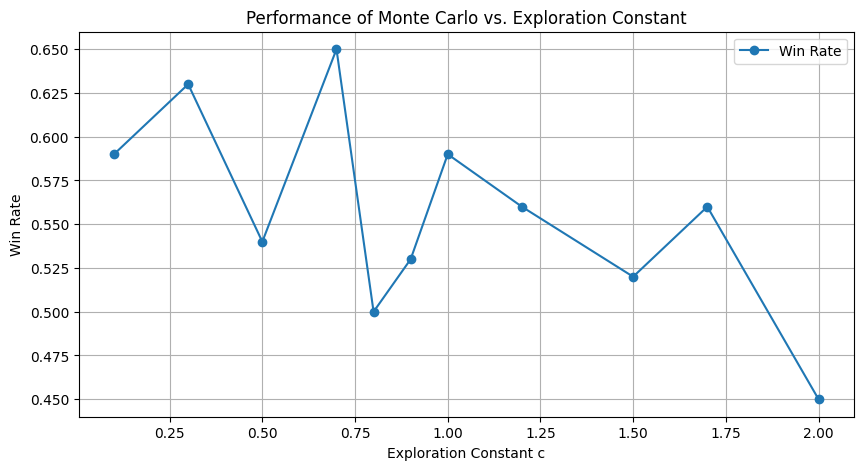

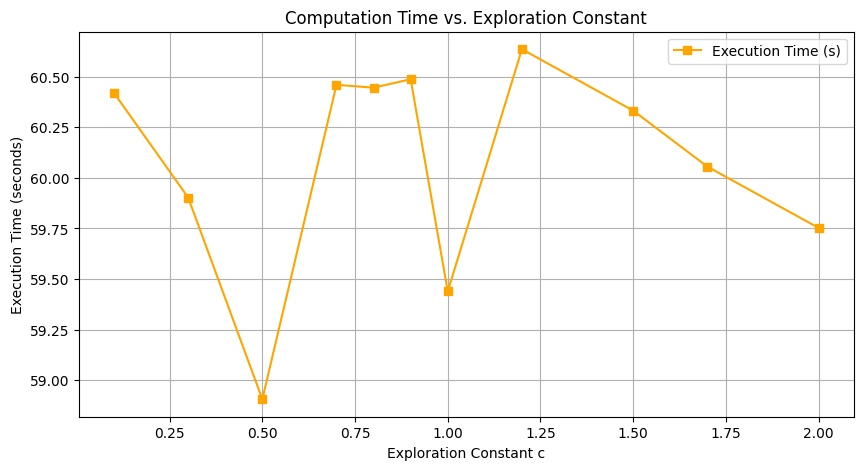

In [ ]:
# Win rate vs c
plt.figure(figsize=(10, 5))
plt.plot(c_values, results, marker='o', label='Win Rate')
plt.xlabel('Exploration Constant c')
plt.ylabel('Win Rate')
plt.title('Performance of Monte Carlo vs. Exploration Constant')
plt.grid(True)
plt.legend()
plt.show()

# Execution time vs c
plt.figure(figsize=(10, 5))
plt.plot(c_values, times, marker='s', color='orange', label='Execution Time (s)')
plt.xlabel('Exploration Constant c')
plt.ylabel('Execution Time (seconds)')
plt.title('Computation Time vs. Exploration Constant')
plt.grid(True)
plt.legend()
plt.show()


### **Testing for 500 games**

In [ ]:
start=time.time()
evaluate_monte_carlo(num_games=500, num_simulations=100,c=0.7)
end=time.time()
print(f"Execution Time: {end - start:.4f} seconds")

Monte Carlo Player:1
{'Alice': 3, 'Bob': 3, 'Charlie': 4}
Monte Carlo player did not win: Charlie 
Monte Carlo Player:0
{'Alice': 3, 'Bob': 6, 'Charlie': 1}
Monte Carlo player did not win: Bob 
Monte Carlo Player:1
{'Alice': 2, 'Bob': 2, 'Charlie': 6}
Monte Carlo player did not win: Charlie 
Monte Carlo Player:1
{'Alice': 6, 'Bob': 2, 'Charlie': 2}
Monte Carlo player did not win: Alice 
Monte Carlo Player:2
{'Alice': 2, 'Bob': 1, 'Charlie': 7}
Monte Carlo player won: Charlie 
Monte Carlo Player:1
{'Alice': 3, 'Bob': 5, 'Charlie': 2}
Monte Carlo player won: Bob 
Monte Carlo Player:1
{'Alice': 1, 'Bob': 6, 'Charlie': 3}
Monte Carlo player won: Bob 
Monte Carlo Player:1
{'Alice': 3, 'Bob': 4, 'Charlie': 3}
Monte Carlo player won: Bob 
Monte Carlo Player:0
{'Alice': 1, 'Bob': 3, 'Charlie': 6}
Monte Carlo player did not win: Charlie 
Monte Carlo Player:0
{'Alice': 7, 'Bob': 2, 'Charlie': 1}
Monte Carlo player won: Alice 
Monte Carlo Player:2
{'Alice': 3, 'Bob': 3, 'Charlie': 4}
Monte Carlo 

### **Monte Carlo vs. Rule-Based Player**

In [ ]:
def rule_based_move(game_state):
    legal_moves = game_state.get_legal_moves()
    return max(legal_moves, key=lambda card: card.rank)


def evaluate_monte_carlo_rule_based(num_games=1000, num_simulations=1000,c=0.707):
    monte_carlo_wins = 0
    win_results = []

    for _ in range(num_games):

        player_names = ["Alice", "Bob", "Charlie"]
        roles = ["Teen", "Do", "Paanch"]
        index = [0, 1, 2]



        game = Game(player_names, roles, index)
        game_state = GameState(game)

        game_state.current_player_index=random.choice(index)
        monte_carlo_player = random.choice(index)
        print(f"Monte Carlo Player:{monte_carlo_player}")


        while not game_state.is_terminal():

            if game_state.current_player_index == monte_carlo_player:
                best_move = ucb_best_move(game_state, num_simulations,c)
            else:
                legal_moves1 = game_state.get_legal_moves()

                if not legal_moves1:
                    print(f"No legal moves for player {game_state.current_player_index}. Ending game.")
                    break

                best_move = rule_based_move(game_state)

            game_state.apply_move(best_move)



        rewards = game_state.tricks_won
        print(rewards)

        max_tricks = max(rewards.values())
        potential_winners = [name for name, count in rewards.items() if count == max_tricks]

        winner_name = potential_winners[0]
        monte_carlo_name = player_names[monte_carlo_player]



        if winner_name == monte_carlo_name:
            monte_carlo_wins += 1
            win_results.append(1)
            print(f"Monte Carlo player won: {winner_name} ")
        else:
            win_results.append(0)
            print(f"Monte Carlo player did not win: {winner_name} ")

    win_rate = monte_carlo_wins / num_games
    std_dev = np.std(win_results, ddof=1)

    print(f"Monte Carlo vs Random Win Rate: {win_rate:.2%}")
    print(f"Standard Deviation of Wins: {std_dev:.4f}")




In [ ]:
start=time.time()
evaluate_monte_carlo_rule_based(num_games=500, num_simulations=100,c=0.7)
end=time.time()
print(f"Execution Time: {end - start:.4f} seconds")

Monte Carlo Player:1
{'Alice': 3, 'Bob': 7, 'Charlie': 0}
Monte Carlo player won: Bob 
Monte Carlo Player:1
{'Alice': 3, 'Bob': 0, 'Charlie': 7}
Monte Carlo player did not win: Charlie 
Monte Carlo Player:1
{'Alice': 7, 'Bob': 1, 'Charlie': 2}
Monte Carlo player did not win: Alice 
Monte Carlo Player:2
{'Alice': 4, 'Bob': 2, 'Charlie': 4}
Monte Carlo player did not win: Alice 
Monte Carlo Player:1
{'Alice': 0, 'Bob': 5, 'Charlie': 5}
Monte Carlo player won: Bob 
Monte Carlo Player:1
{'Alice': 4, 'Bob': 5, 'Charlie': 1}
Monte Carlo player won: Bob 
Monte Carlo Player:2
{'Alice': 6, 'Bob': 1, 'Charlie': 3}
Monte Carlo player did not win: Alice 
Monte Carlo Player:1
{'Alice': 1, 'Bob': 5, 'Charlie': 4}
Monte Carlo player won: Bob 
Monte Carlo Player:2
{'Alice': 4, 'Bob': 1, 'Charlie': 5}
Monte Carlo player won: Charlie 
Monte Carlo Player:1
{'Alice': 3, 'Bob': 1, 'Charlie': 6}
Monte Carlo player did not win: Charlie 
Monte Carlo Player:1
{'Alice': 5, 'Bob': 3, 'Charlie': 2}
Monte Carlo pl